In [2]:
from datasets import load_dataset
import pinecone

pinecone.init(api_key="e09feacb-dc2e-4911-b320-221ff119e304", environment="northamerica-northeast1-gcp")

dataset = load_dataset("hugginglearners/netflix-shows")

Found cached dataset csv (/Users/rdubey/.cache/huggingface/datasets/hugginglearners___csv/hugginglearners--netflix-shows-03475319fc65a05a/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
pinecone.list_indexes()

[]

In [7]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Steps
1. Take input query, parse and generate embeddings
2. Use ANN to find nearest neighbors (100) from TV show descriptions
3. Use Cross Encoder to find most similar to query

In [8]:
df_train = dataset['train'].to_pandas()
df_train.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,None,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."
1,s2,TV Show,Blood & Water,None,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",None,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war."
3,s4,TV Show,Jailbirds New Orleans,None,None,None,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series."
4,s5,TV Show,Kota Factory,None,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life."


In [25]:
df_train[df_train['duration'].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,num_seasons
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,None,Movies,"Louis C.K. muses on religion, eternal love, giving dogs drugs, email fights, teachers and more in a live performance from Washington, D.C.",NaN
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,None,Movies,"Emmy-winning comedy writer Louis C.K. brings his caustic wit to Milwaukee, offering up his unique and uncensored take on sex, parenting and more.",NaN
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,None,Movies,"The comic puts his trademark hilarious/thought-provoking spin on finding a bat in his kitchen, seeing rats having sex, Boston accents and dead pets.",NaN


In [36]:
df_train.loc[df_train['duration'].isna(), 'duration'] = df_train['rating']

In [37]:
df_train[df_train['duration'].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,num_seasons


In [38]:
def get_num_seasons(row):
    if row['type'] == 'TV Show':
        d = row['duration'].split(" ")[0]
        return int(d)
def get_running_time(row):
    if row['type'] == 'Movie':
        t = row['duration'].split(" ")[0]
        return float(t)/60
df_train['num_seasons'] = df_train.apply(get_num_seasons, axis=1)
df_train['running_time'] = df_train.apply(get_running_time, axis=1)

In [39]:
df_train.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,num_seasons,running_time
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,None,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.",NaN,1.5
1,s2,TV Show,Blood & Water,None,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.",2.0,NaN
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",None,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.",1.0,NaN
3,s4,TV Show,Jailbirds New Orleans,None,None,None,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series.",1.0,NaN
4,s5,TV Show,Kota Factory,None,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life.",2.0,NaN


<AxesSubplot: >

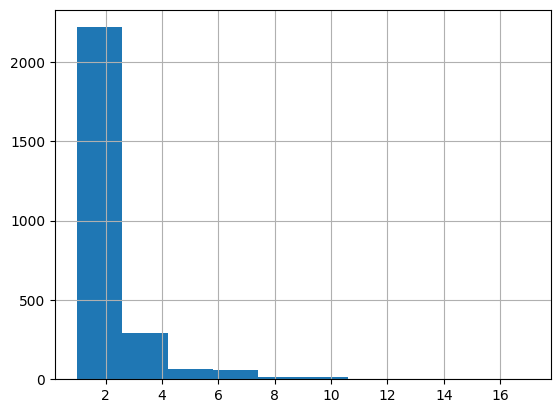

In [17]:
df_train['num_seasons'].hist()

In [52]:
df_train.columns[df_train.isna().any()].tolist()

['director',
 'cast',
 'country',
 'date_added',
 'rating',
 'num_seasons',
 'running_time']

In [94]:
from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [99]:
from langchain.embeddings import HuggingFaceEmbeddings

In [101]:
embedder = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

In [112]:
len(embedder.embed_documents(["hello world"])[0])

384

In [130]:
index_name = 'langchain-netflix-data'
# we create a new index
pinecone.create_index(
    name=index_name,
    metric='dotproduct',
    dimension=len(embeds[0])
)

In [131]:
active_indexes = pinecone.list_indexes()
active_indexes

['langchain-netflix-data']

In [134]:
index = pinecone.Index("langchain-netflix-data")

In [155]:
from tqdm.auto import tqdm
from uuid import uuid4

batch_limit = 100

texts = []
metadatas = []
ids = []

for i, record in tqdm(df_train.iterrows()):
    title = record['title']
    show_type = record['type']
    categories_list = ', '.join([s.strip() for s in record['listed_in'].split(",")]) if record['listed_in'] else []
    country_list = [s.strip() for s in record['country'].split(",")] if record['country'] else []
    cast = record['cast'] or ''
    ids.append(record['show_id'])
    metadata = {
        'show_type': show_type,
        'country': country_list,
        'categories': categories_list,
        'title': record['title'],
        'about': record['description'],
    }
    text = f"'{record['title']}' is a {record['type']}."
    # add cast info
    text += f" It stars {cast}." if len(cast)>0 else ""
    # add description
    text += f" It can be described as: {record['description']}"
    # add category info
    text += f" It is listed under the categories: {categories}" if len(categories)>0 else ''

    texts.append(text)
    metadatas.append(metadata)
    # if we have reached the batch_limit we can add texts
    if len(texts) >= batch_limit:
        embeds = embedder.embed_documents(texts)
        data_to_index = list(zip(ids, embeds, metadatas))
#         print(data_to_index)
#         break
        index.upsert(vectors=zip(ids, embeds, metadatas))
        texts = []
        metadatas = []
        ids = []
     
    

0it [00:00, ?it/s]

In [152]:
text

"'Zubaan' is a Movie. It stars Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanana, Manish Chaudhary, Meghna Malik, Malkeet Rauni, Anita Shabdish, Chittaranjan Tripathy. It can be described as: A scrappy but poor boy worms his way into a tycoon's dysfunctional family, while facing his fear of music and the truth about his past. It is listed under the categories: Dramas, International Movies, Music & Musicals"

In [137]:
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 8800}},
 'total_vector_count': 8800}

In [139]:
from langchain.vectorstores import Pinecone

In [140]:
text_field = "about"

# switch back to normal index for langchain
vectorstore = Pinecone(
    index, embedder.embed_query, text_field
)

In [154]:
query = "suggest a movie stars Vicky Kaushal"

vectorstore.similarity_search(
    query,  # our search query
    k=3  # return 3 most relevant docs
)

[Document(page_content='Kabir Singh: An exalted but short-fused surgeon plunges into a spiral of drugs, alcohol and rage after his intense relationship with his girlfriend turbulently ends.', lookup_str='', metadata={'categories': 'Dramas, International Movies, Romantic Movies', 'country': ['India'], 'show_type': 'Movie'}, lookup_index=0),
 Document(page_content="Kurbaan: When a young Indian couple moves to the American suburbs, they are shocked to discover that they've become enmeshed in a secret terrorist plot.", lookup_str='', metadata={'categories': 'International Movies, Thrillers', 'country': ['India'], 'show_type': 'Movie'}, lookup_index=0),
 Document(page_content='Maine Pyaar Kyun Kiya: After lying to his girlfriend, orthopedic surgeon Samir must conjure up a pretend wife in this musical comedy.', lookup_str='', metadata={'categories': 'Comedies, International Movies, Music & Musicals', 'country': ['India'], 'show_type': 'Movie'}, lookup_index=0)]

In [ ]:
vectorstore